In [29]:
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import ensemble
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error, plot_confusion_matrix
from sklearn import ensemble
from sklearn import metrics

# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit.Chem.SaltRemover import SaltRemover

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# plots
from matplotlib import pyplot
import seaborn

# other packages
import pandas as pd
import numpy as np
import csv
import re
import gzip

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (C:\Users\install\miniconda3\envs\cdd2023\lib\site-packages\sklearn\metrics\__init__.py)

In [2]:
sr = SaltRemover() # from rdkit
m = Chem.MolFromSmiles("[Na+].C(=O)[O-]")
print(Chem.MolToSmiles(sr(m)))

O=C[O-]


In [3]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [4]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

In [7]:
mols = []
with gzip.open('../data/rock1/actives_final.sdf.gz', 'r') as sdf:
    suppl = Chem.ForwardSDMolSupplier(sdf)
    for i,mol in enumerate(suppl):
        mol = standardize(mol)
        if mol:
            mols.append({
                 "source":"active_rock",
                 "rdmol": mol,
                 "smiles": Chem.MolToSmiles(mol),
                 #"pChEMBL_value": 0,
                 # Chem.MolToInchiKey(mol),
                 "fps": Chem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)
                }
            )
with gzip.open('../data/rock1/decoys_final.sdf.gz', 'r') as sdf:
    suppl = Chem.ForwardSDMolSupplier(sdf)
    for i,mol in enumerate(suppl):
        mol = standardize(mol)
        if mol:
            mols.append({
                 "source":"decoy_rock",
                 "smiles": Chem.MolToSmiles(mol),
                 "rdmol": mol,
                 #"pChEMBL_value": 0,
                 # Chem.MolToInchiKey(mol),
                 "fps": Chem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)
                }
            )

In [9]:
# let's work with Pandas dataframe
df = pd.DataFrame(mols, columns=["smiles","source", "rdmol", "fps"])
# adds index as normal column
df.reset_index(level=0, inplace=True)

In [14]:
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )

In [17]:
df_train, df_test = ms.train_test_split(df,stratify=df["source"])

In [20]:
rf = ensemble.RandomForestClassifier()
rf.fit(list(df_train["fps"]), df_train["source"])

RandomForestClassifier()

In [74]:
res = rf.predict(list(df_test["fps"]))

In [75]:
metrics.confusion_matrix(df_test["source"], res)

array([[  46,    5],
       [   0, 1592]], dtype=int64)

In [35]:
rf2 = ensemble.RandomForestClassifier()
rf2.fit(df_train[(f"MQN_{x}" for x in range(1,43))], df_train["source"])

RandomForestClassifier()

In [38]:
res2 = rf2.predict(df_test[(f"MQN_{x}" for x in range(1,43))])
metrics.confusion_matrix(df_test["source"], res2)

array([[  44,    7],
       [   1, 1591]], dtype=int64)

In [45]:
metrics.f1_score(df_test["source"], res2, pos_label="active_rock"), metrics.f1_score(df_test["source"], res, pos_label="active_rock")

(0.9166666666666665, 0.9484536082474228)

In [51]:
fp=Chem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles("CCCCCC"),2,nBits=1024)
list(bool(int(x)) for x in fp.ToBitString())

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 F

In [52]:
list(df_train["fps"])

 ...]

In [54]:
rf3 = ensemble.RandomForestClassifier()
rf3.fit(list([bool(int(fp.ToBitString())) for ] for fp in df["fps"]), df_train["source"])

ValueError: Expected 2D array, got 1D array instead:
array=[1. 1. 1. ... 1. 1. 1.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [62]:
mols=[]
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")
with open("../data/chembl_mtor_ic50.csv") as inp:
    for row in csv.DictReader(inp, delimiter=";", quotechar='"'):
        row["rdmol"] = Chem.MolFromSmiles(row["Smiles"])
        row["smiles"] = row["Smiles"]
        row["source"] = "mtor"
        row["pChEMBL_value"] = float(row["pChEMBL Value"]) if float_pattern.match(row["pChEMBL Value"]) else 0
        
        mol = standardize(row["rdmol"])
        if mol and row["pChEMBL_value"]:
            fp = Chem.GetMorganFingerprintAsBitVect(row["rdmol"],2,nBits=1024)
            mols.append({
                    "smiles": Chem.MolToSmiles(mol),
                     "source":"mtor",
                     "rdmol": mol,
                     "pChEMBL_value": row["pChEMBL_value"],
                     # Chem.MolToInchiKey(mol),
                     "fps": fp
                    }
                )

In [63]:
# let's work with Pandas dataframe
mtor = pd.DataFrame(mols, columns=["smiles","source", "rdmol", "fps", "pChEMBL_value"])
# adds index as normal column
mtor.reset_index(level=0, inplace=True)

In [80]:
mtor = mtor.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in mtor["rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )

In [81]:
mtor_train, mtor_test = ms.train_test_split(mtor)

In [82]:
rr = ensemble.RandomForestRegressor()
rr.fit(list(mtor_train["fps"]), mtor_train["pChEMBL_value"])

RandomForestRegressor()

In [83]:
rres = rr.predict(list(mtor_test["fps"]))

In [84]:
metrics.mean_squared_error(mtor_test["pChEMBL_value"], rres), metrics.r2_score(mtor_test["pChEMBL_value"], rres)

(0.37138580084436146, 0.7210072749341705)

<Axes: ylabel='pChEMBL_value'>

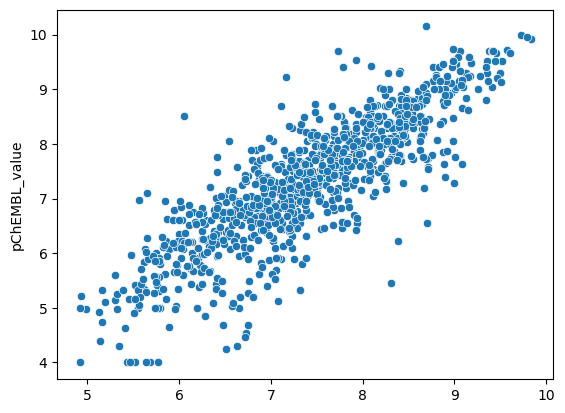

In [85]:
seaborn.scatterplot(x=rres,y=mtor_test["pChEMBL_value"])

<Axes: ylabel='pChEMBL_value'>

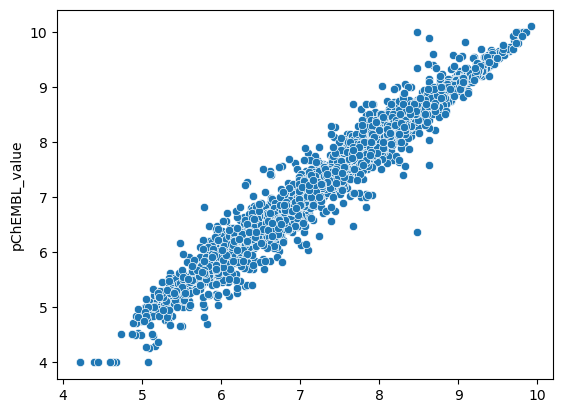

In [86]:
seaborn.scatterplot(x=rr.predict(list(mtor_train["fps"])),y=mtor_train["pChEMBL_value"])

In [87]:
rr2 = ensemble.RandomForestRegressor()
rr2.fit(mtor_train[(f"MQN_{x}" for x in range(1,43))], mtor_train["pChEMBL_value"])

RandomForestRegressor()

In [89]:
rres2 = rr2.predict(mtor_test[(f"MQN_{x}" for x in range(1,43))])

In [90]:
metrics.mean_squared_error(mtor_test["pChEMBL_value"], rres2), metrics.r2_score(mtor_test["pChEMBL_value"], rres2)

(0.49308366833151007, 0.6295853099378066)

<Axes: ylabel='pChEMBL_value'>

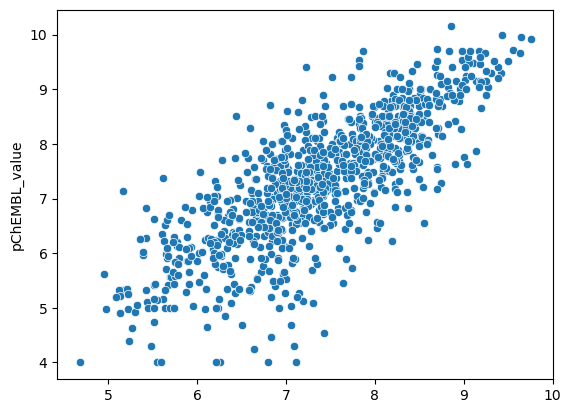

In [91]:
seaborn.scatterplot(x=rres2,y=mtor_test["pChEMBL_value"])

In [92]:
mtor

,index,smiles,source,rdmol,fps,pChEMBL_value,MQN_1,MQN_2,MQN_3,MQN_4,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
0,0,CC(=O)Nc1nc2ccc(-c3ccnc(NS(=O)(=O)c4ccccc4F)n3...,mtor,<rdkit.Chem.rdchem.Mol object at 0x00000237591...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",7.35,19,1,0,0,...,0,0,1,3,0,0,0,0,2,1
1,1,CC(=O)Nc1nc2ccc(-c3ccnc(NS(=O)(=O)c4ccc(F)cc4)...,mtor,<rdkit.Chem.rdchem.Mol object at 0x00000237591...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.14,19,1,0,0,...,0,0,1,3,0,0,0,0,2,1
2,2,COc1ccc(S(=O)(=O)Nc2cccc(-c3ccc4nc(NC(C)=O)sc4...,mtor,<rdkit.Chem.rdchem.Mol object at 0x000002374B6...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.82,22,0,0,0,...,0,0,1,3,0,0,0,0,2,1
3,3,O=c1[nH]c2ncc(-c3ccc(O)cc3)nc2n1C1CCOCC1,mtor,<rdkit.Chem.rdchem.Mol object at 0x000002374B6...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.78,16,0,0,0,...,0,0,1,3,0,0,0,0,2,1
4,4,CC(C)(O)c1ccc(-c2cnc3[nH]c(=O)n(CC4CCCCC4)c3n2...,mtor,<rdkit.Chem.rdchem.Mol object at 0x000002374B6...,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.52,21,0,0,0,...,0,0,1,3,0,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3922,3922,CCNC(=O)Nc1ccc(-c2nc3c(c(N4CCOC[C@@H]4C)n2)CCN...,mtor,<rdkit.Chem.rdchem.Mol object at 0x0000023758F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.41,24,0,0,0,...,0,1,0,4,0,0,0,0,2,1
3923,3923,COc1ncc(-c2ccc3ncn([C@H]4CCN(C(=O)C5CC5)C4)c(=...,mtor,<rdkit.Chem.rdchem.Mol object at 0x0000023758F...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.68,28,1,0,0,...,1,0,1,4,0,0,0,0,2,1
3924,3924,COc1ncc(-c2ccc3ncc(Cl)c(=O)n3c2)cc1NS(=O)(=O)c...,mtor,<rdkit.Chem.rdchem.Mol object at 0x0000023758F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.33,20,2,1,0,...,0,0,0,4,0,0,0,0,2,1
3925,3925,C=CC(=O)Nc1ccc(-n2c(=O)ccc3oc4ccc(-c5cccnc5)cc...,mtor,<rdkit.Chem.rdchem.Mol object at 0x0000023758F...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.64,25,0,0,0,...,0,0,1,4,0,0,0,0,4,2
